In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
prolongations = pd.read_csv('prolongations.csv')
prolongations.head(3)

dic_for_russian_month = {'январь': '01', 'февраль': '02', 'март': '03', 'апрель': '04',
    'май': '05', 'июнь': '06', 'июль': '07', 'август': '08',
    'сентябрь': '09', 'октябрь': '10', 'ноябрь': '11', 'декабрь': '12'}
prolongations.head(3)


,id,month,AM
0,42,ноябрь 2022,Васильев Артем Александрович
1,453,ноябрь 2022,Васильев Артем Александрович
2,548,ноябрь 2022,Михайлов Андрей Сергеевич


In [76]:
finincial = pd.read_csv('financial_data.csv')
finincial.head(3)

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
0,42,NaN,"36 220,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
1,657,первая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
2,657,вторая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович


Index(['id', 'month', 'AM'], dtype='object')

In [77]:
# Данные объединяются по уникальному идентификатору проекта (id)
contracts = prolongations.merge(finincial, left_on = 'id', right_on = 'id', how = 'inner')
print(len(contracts))
print(len(prolongations), len(finincial))
contracts.head(3)
contracts['id'].value_counts() ###


725
477 451


id
154     18
798     15
797     12
914     12
708     10
        ..
747      1
42       1
955      1
1004     1
913      1
Name: count, Length: 313, dtype: int64

In [78]:
import re
def clean_num_str(s):
    if not isinstance(s, str):
        return s
    s = re.sub(r'\s+', '', s)
    s = s.replace(',', '.')
    return s

In [98]:


from dateutil.relativedelta import relativedelta
# такие инлдексы выбрал тк заранее посмотрел columns (индексы лдя месяцев)
contracts[contracts.columns[4:-1]] = contracts[contracts.columns[4:-1]].replace('в ноль', 0)
contracts = contracts.drop_duplicates('id', keep = 'last')

for i in range(4, len(contracts.columns) - 1):
    contracts = contracts[~(contracts[contracts.columns[i]].isin(['стоп', 'end']) )]
print(len(contracts), "длина итогового датафрейма после исключения строк со стоп и end и дупликатов")

new_columns = list(contracts.columns)
# со строчной буквы будут колонки
new_columns[4:-1] = [x.lower() for x in contracts.columns[4:-1]]
contracts.columns = new_columns

contracts[contracts.columns[4:-1]] = contracts[contracts.columns[4:-1]].fillna(0)

for i in range(4, len(contracts.columns) - 1):
    col = contracts.columns[i]
    contracts[col] = contracts[col].apply(lambda x: float(clean_num_str(x)))
    contracts[col] = pd.to_numeric(contracts[col], errors='coerce').fillna(0).astype(float)

contracts.info()


263 длина итогового датафрейма после исключения строк со стоп и end и дупликатов
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 724
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             263 non-null    int64  
 1   month          263 non-null    object 
 2   AM             263 non-null    object 
 3   Причина дубля  136 non-null    object 
 4   ноябрь 2022    263 non-null    float64
 5   декабрь 2022   263 non-null    float64
 6   январь 2023    263 non-null    float64
 7   февраль 2023   263 non-null    float64
 8   март 2023      263 non-null    float64
 9   апрель 2023    263 non-null    float64
 10  май 2023       263 non-null    float64
 11  июнь 2023      263 non-null    float64
 12  июль 2023      263 non-null    float64
 13  август 2023    263 non-null    float64
 14  сентябрь 2023  263 non-null    float64
 15  октябрь 2023   263 non-null    float64
 16  ноябрь 2023    263 non

In [80]:
month_names = {
        1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель',
        5: 'май', 6: 'июнь', 7: 'июль', 8: 'август',
        9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь'
    }

def determine_month(current_month):
    current_month_date = pd.to_datetime(f"{dic_for_russian_month[current_month.split()[0]]}-01-{current_month.split()[1]}")
    prev_month_date = current_month_date - relativedelta(months=1)
    prev2_month_date = current_month_date - relativedelta(months=2)
    prev_month = f"{month_names[prev_month_date.month]} {prev_month_date.year}"
    prev2_month = f"{month_names[prev2_month_date.month]} {prev2_month_date.year}"
    return prev_month, prev2_month

In [99]:
current_month = 'февраль 2023'

# Вычисляет оба коэффициента для месяца, которыеый мы предаём
def find_coeffs_monthly(contracts, current_month):
    contracts1 = contracts.copy()
    print(len(contracts1))
    prev_month, prev2_month = determine_month(current_month)
    print(prev_month, prev2_month)
    
    contracts1 = contracts1[contracts1['month'] == prev_month]
    if not contracts1.empty:
        contracts1.columns
        contracts1 = contracts1.groupby('AM').sum(numeric_only= True).reset_index()
        contracts1['calculate_month'] = current_month
        contracts1.loc[len(contracts1)] = ['Company', np.nan] + [contracts1[col].sum() for col in contracts1.columns[2:-1]] + [current_month]
    # Первый коэффициент пролонгации
        contracts1['coeff1'] = contracts1[current_month] / contracts1[prev_month]

    
    contracts2 = contracts.copy()
    contracts2 = contracts2[contracts2['month'] == prev2_month]
    if not contracts2.empty:
        contracts2 = contracts2.groupby('AM').sum(numeric_only= True).reset_index()
        contracts2['calculate_month'] = current_month 
        contracts2 = contracts2[contracts2[prev_month] == 0]
        contracts2.loc[len(contracts2)] = ['Company', np.nan] + [contracts2[col].sum() for col in contracts2.columns[2:-1]] + [current_month]
        contracts2['coeff2'] = contracts2[current_month] / contracts2[prev2_month]
        
    return contracts1, contracts2

df_first_all, df_second_all = [], []
months_in_datas = [col for col in contracts.columns[4:-1]]

for month in months_in_datas:
    #Набираем датафреймы с раными месяцами в список
    df_first, df_second = find_coeffs_monthly(contracts, month)
    df_first_all.append(df_first)
    df_second_all.append(df_second)

def clean_dataframe(df):
    # Преобразуем все столбцы в строки и чистим их
    df = df.copy()
    for col in df.columns:
        df[col] = df[col].astype(str).str.encode('utf-8', errors='ignore').str.decode('utf-8')
    return df

# Запись в эксель в листах ratio_i + месяц 
with pd.ExcelWriter('Ratios_prolongations_for_every_month.xlsx', engine='openpyxl') as writer:
    for i, month in enumerate(months_in_datas):
        if df_first_all[i] is not None and len(df_first_all[i]) > 0:
            sheet_name = 'ratio1_' + month.replace(' ', '_')[:31]  # ограничиваем длину имени ###
            clean_dataframe(df_first_all[i]).to_excel(writer, sheet_name=sheet_name, index=False)
        
        if df_second_all[i] is not None and len(df_second_all[i]) > 0:
            sheet_name = 'ratio2_' + month.replace(' ', '_')[:31]
            clean_dataframe(df_second_all[i]).to_excel(writer, sheet_name=sheet_name, index=False)

263
октябрь 2022 сентябрь 2022
263
ноябрь 2022 октябрь 2022
263
декабрь 2022 ноябрь 2022
263
январь 2023 декабрь 2022
263
февраль 2023 январь 2023
263
март 2023 февраль 2023
263
апрель 2023 март 2023
263
май 2023 апрель 2023
263
июнь 2023 май 2023
263
июль 2023 июнь 2023
263
август 2023 июль 2023
263
сентябрь 2023 август 2023
263
октябрь 2023 сентябрь 2023
263
ноябрь 2023 октябрь 2023
263
декабрь 2023 ноябрь 2023
263
январь 2024 декабрь 2023


In [102]:
result_first_ratio, result_second_ratio = pd.concat(df_first_all, ignore_index= True), pd.concat(df_second_all, ignore_index= True)
result_first_ratio.sample(5)

,id,month,AM,Причина дубля,ноябрь 2022,декабрь 2022,январь 2023,февраль 2023,март 2023,апрель 2023,...,август 2023,сентябрь 2023,октябрь 2023,ноябрь 2023,декабрь 2023,январь 2024,февраль 2024,Account,calculate_month,coeff1
10,2353.0,NaN,Соколова Анастасия Викторовна,NaN,396685.21,468452.76,83880.0,137960.0,133970.0,131155.0,...,46995.0,46995.0,46995.0,46995.0,46995.0,46995.0,0.0,NaN,январь 2023,0.179058
19,555.0,NaN,Иванова Мария Сергеевна,NaN,127200.00,127200.00,127200.0,127200.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,март 2023,0.000000
45,858.0,NaN,Смирнова Ольга Владимировна,NaN,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,июль 2023,NaN
8,1728.0,NaN,Попова Екатерина Николаевна,NaN,99035.00,137125.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,январь 2023,0.000000
73,3113.0,NaN,Васильев Артем Александрович,NaN,0.00,0.00,0.0,0.0,0.0,0.0,...,168400.0,155060.0,150060.0,169720.0,55000.0,0.0,0.0,NaN,декабрь 2023,0.324063


In [91]:
# Коэффициенты пролонгаций за каждый год
years = ['2022', '2023', '2024']
yearly_ratios = []

# Вычисляем для каждого года и сотрудника среднее значение коэффициентов
for year in years:
    result_first_ratio_yearly = result_first_ratio[result_first_ratio['calculate_month'].str[-4:] == year]
    result_first_ratio_yearly = result_first_ratio_yearly.groupby('AM').mean(numeric_only= True).reset_index()[['AM', 'coeff1']]
    result_first_ratio_yearly['year'] = year
    
    result_second_ratio_yearly = result_second_ratio[result_second_ratio['calculate_month'].str[-4:] == year]
    result_second_ratio_yearly = result_second_ratio_yearly.groupby('AM').mean(numeric_only= True).reset_index()[['AM', 'coeff2']]
    result_second_ratio_yearly['year'] = year

    yearly_ratios.append((result_first_ratio_yearly, result_second_ratio_yearly))

result_first_ratio_yearly

# Запись в excel
with pd.ExcelWriter('Ratios_prolongations_for_every_year(2).xlsx', engine='openpyxl') as writer:
    for i, year in enumerate(years):
        yearly_ratios1, yearly_ratios2 = yearly_ratios[i]
        if yearly_ratios1 is not None and len(yearly_ratios1) > 0:
            sheet_name = 'ratio1_' + year[:31]  # ограничиваем длину имени ###
            clean_dataframe(yearly_ratios1).to_excel(writer, sheet_name=sheet_name, index=False)
        if yearly_ratios2 is not None and len(yearly_ratios2) > 0:
            sheet_name = 'ratio2_' + year[:31] 
            clean_dataframe(yearly_ratios2).to_excel(writer, sheet_name=sheet_name, index=False)

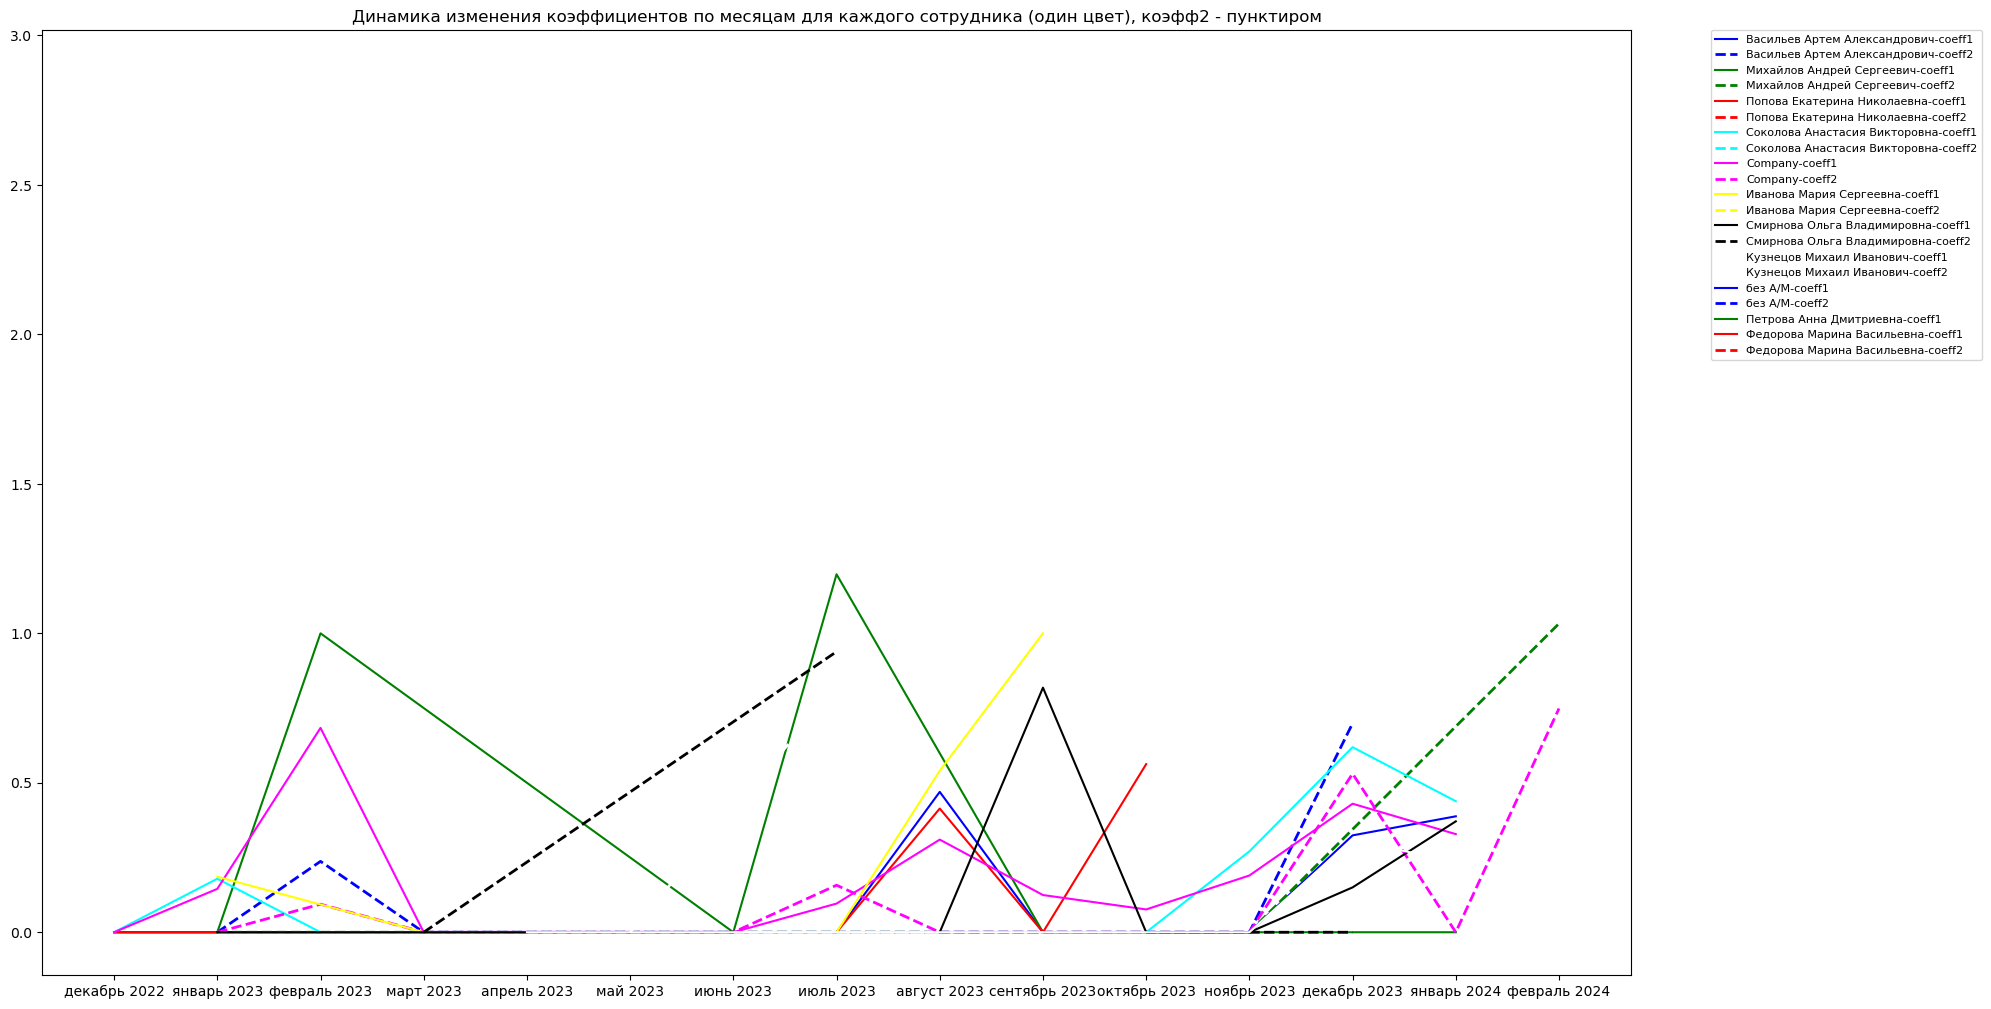

In [96]:
# Ищем всех сотрудников
ams = list(dict.fromkeys(np.concatenate([result_first_ratio['AM'].unique(), result_second_ratio['AM'].unique()] )))
fig = plt.figure(figsize=(20, 10))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']

# Отображаем динамику изменеия коэффициентов для каждого сотрудника на графике
for i, am in enumerate(ams):
    ams_first_ratio = result_first_ratio[result_first_ratio['AM'] == am]
    ams_second_ratio = result_second_ratio[result_second_ratio['AM'] == am]
    if len(ams_first_ratio) > 0:
        plt.plot(ams_first_ratio['calculate_month'], ams_first_ratio['coeff1'], label = f'{am}-coeff1', color = colors[i%len(colors)])
    if len(ams_second_ratio) > 0:
        plt.plot(ams_second_ratio['calculate_month'], ams_second_ratio['coeff2'], label = f'{am}-coeff2', 
                 color = colors[i%len(colors)], linestyle = '--', linewidth = 2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
plt.tight_layout()
plt.title('Динамика изменения коэффициентов по месяцам для каждого сотрудника (один цвет), коэфф2 - пунктиром')
plt.savefig('Динамика изменения коэффициентов по месяцам для каждого сотрудника', bbox_inches = 'tight')
plt.show()

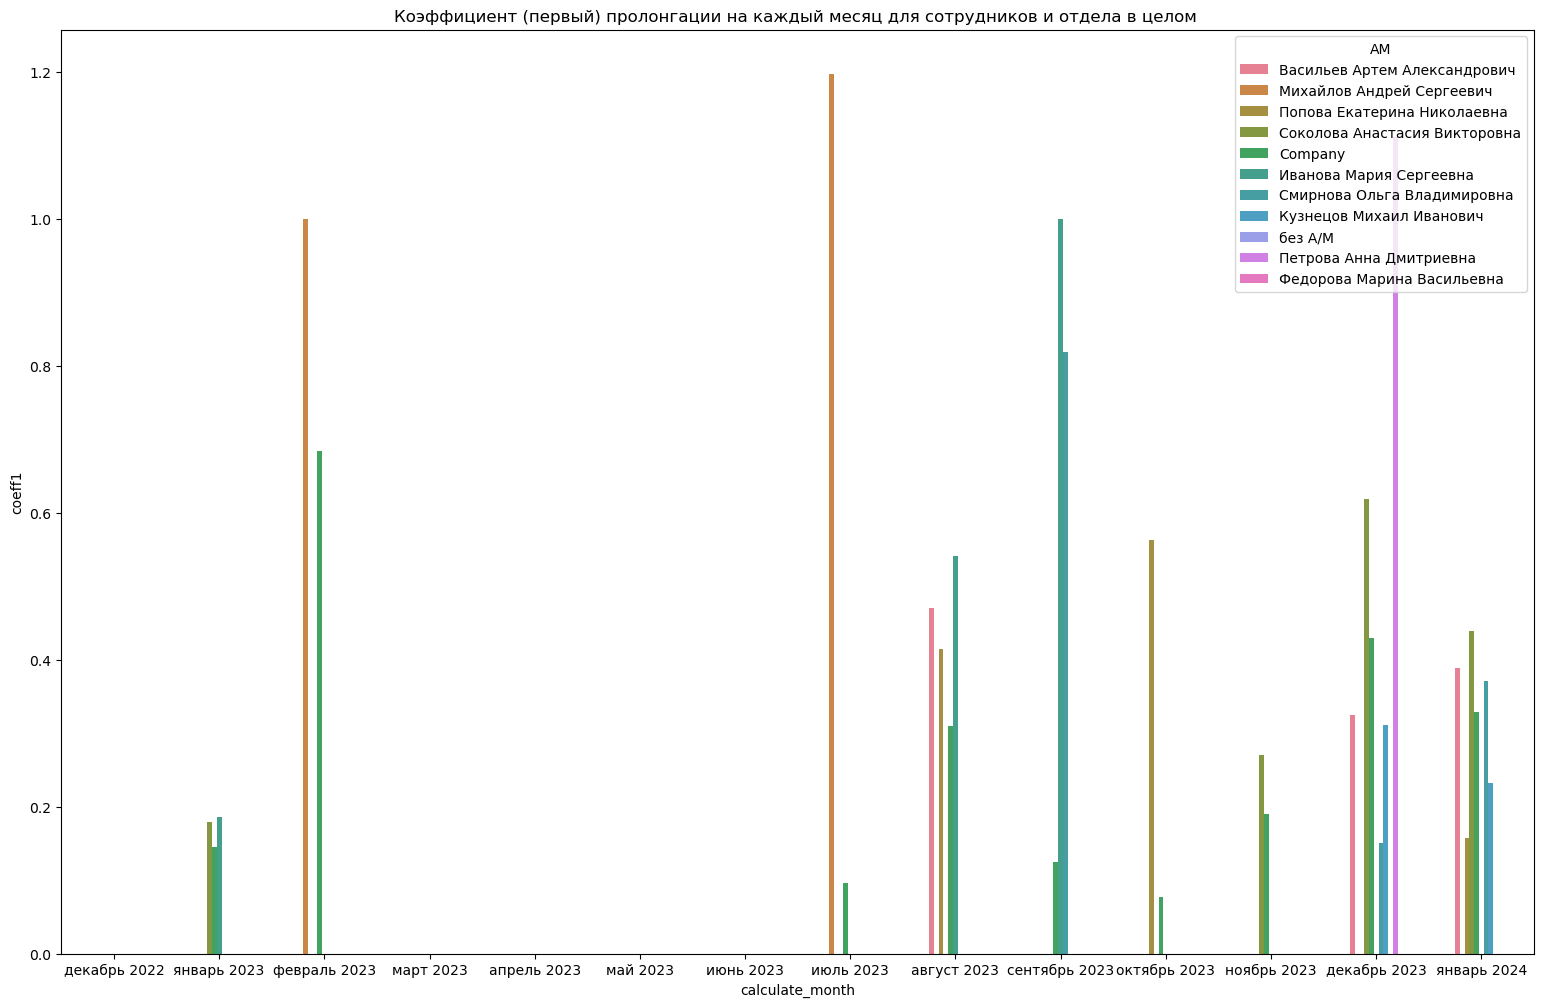

In [93]:
fig = plt.figure(figsize = (19, 12))
axes = sns.barplot(data = result_first_ratio, x = 'calculate_month', y = 'coeff1', hue = 'AM', width= 0.5)
axes.set_title('Коэффициент (первый) пролонгации на каждый месяц для сотрудников и отдела в целом ')
plt.savefig('Ratio_prolongation_first_for_every_month', bbox_inches = 'tight')
plt.show()

('январь 2023', 'декабрь 2022')

In [19]:
import pytest
def test_spaces():
    assert clean_num_str("1 000 000") == "1000000"
def test_commas():
    assert clean_num_str("123,45") == "123.45"
def test_determining_month():
    prev, prev2 = determine_month('август 2023')
    assert prev == 'июль 2023'
    assert prev2 == 'июнь 2023'

test_spaces()
test_commas()
test_determining_month()
print('все тесты пройдены')

все тесты пройдены


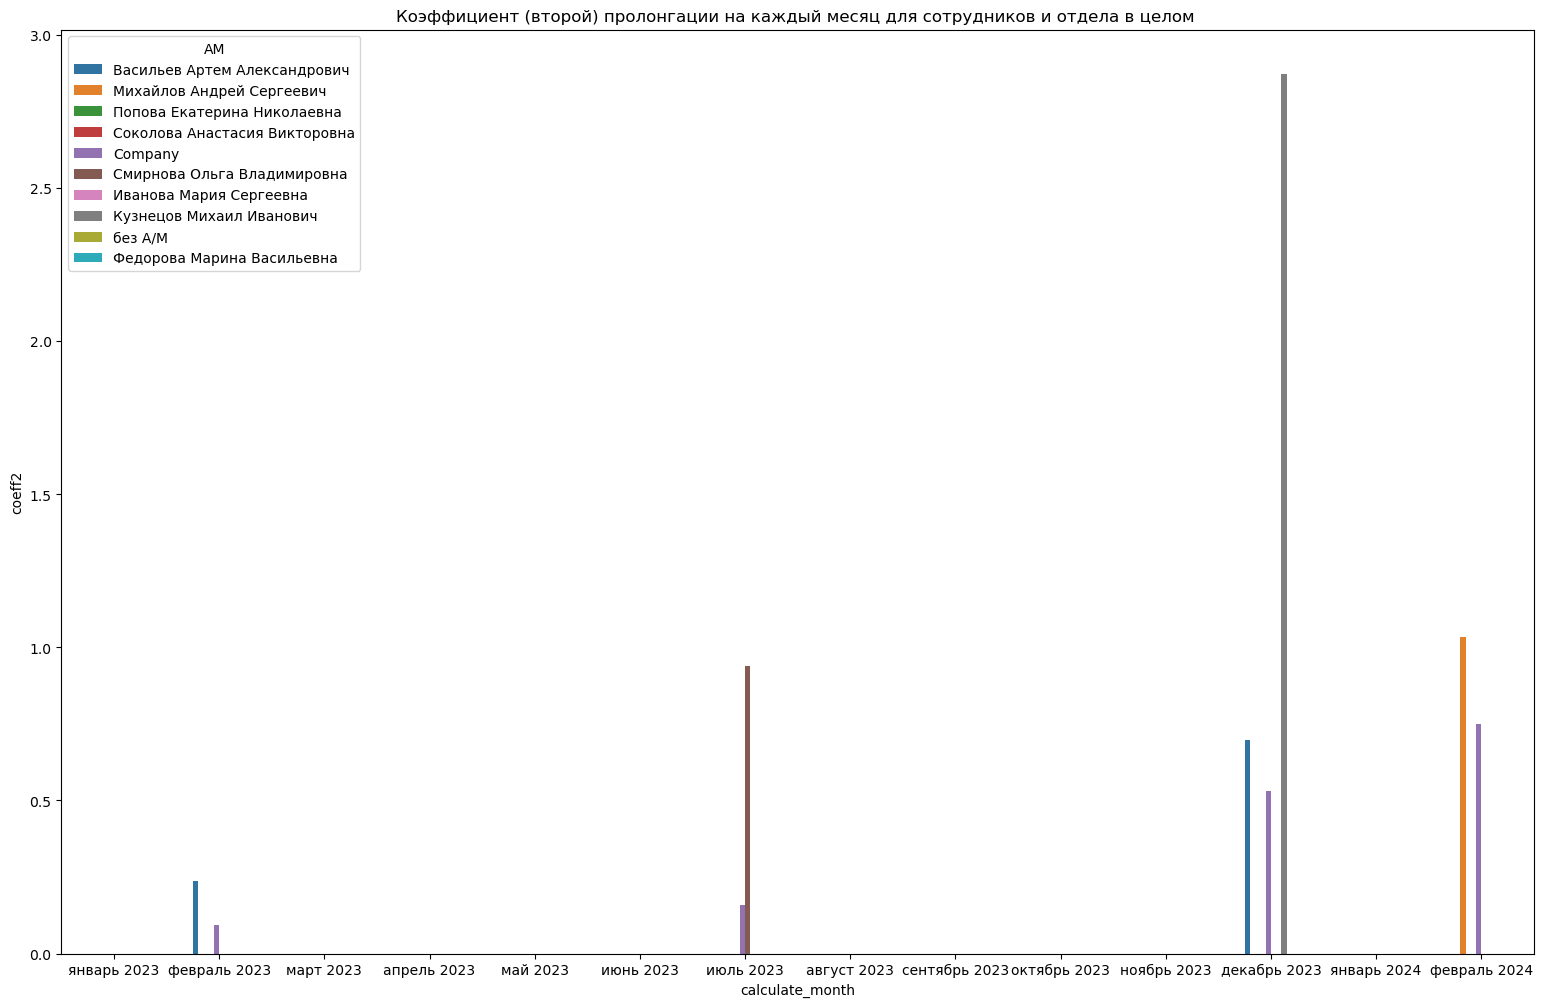

In [94]:
fig = plt.figure(figsize = (19, 12))
axes = sns.barplot(data = result_second_ratio, x = 'calculate_month', y = 'coeff2', hue = 'AM', width= 0.5)
axes.set_title('Коэффициент (второй) пролонгации на каждый месяц для сотрудников и отдела в целом ')
plt.savefig('Ratio_prolongation_second_for_every_month', bbox_inches = 'tight')
plt.show()

In [103]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['text.usetex'] = True  # Включить LaTeX рендеринг

# Аналитический отчет по коэффициентам пролонгации

## Цель задачи
Руководитель отдела хочет получить оценку того, насколько успешно аккаунт-менеджеры продлевают договоры с клиентами. Для этого рассчитываются два коэффициента пролонгации по каждому месяцу, а также итоговые показатели за весь год.

## Этапы проведения анализа

1. **Объединение данных**  
   Данные из файлов `prolongations.csv` и `financial_data.csv` объединяются по уникальному идентификатору проекта (`id`).

2. **Очистка и подготовка данных**  
   Значения отгрузок приводятся к единому формату: удаляются лишние пробелы, заменяются запятые на точки, обрабатываются пропуски и специальные метки (`'в ноль'`, `'стоп'`, `'end'`).

3. **Формирование временных рядов отгрузок**  
   Группируются данные по сотрудникам и аггрегируются по отгрузкам месяцев

4. **Вычисление коэффициентов пролонгации**  
   Для каждого месяца рассчитываются два показателя:  
   - Первый коэффициент — отношение суммы отгрузок проектов, пролонгированных в первый месяц после завершения, к сумме отгрузок в последний месяц реализации.  
   - Второй коэффициент — отношение суммы отгрузок проектов, пролонгированных во второй месяц, к сумме отгрузок проектов, не пролонгированных в первый месяц.

5. **Подведение итогов за год**  
   Рассчитываются средние значения коэффициентов по всем месяцам для каждого менеджера и для отдела в целом, который у меня указан как 'Company'.

6. **Формирование и сохранение отчета**  
   Итоговый отчет экспортируется в Excel-файл
   Как отчет по месяцам, так и отчёт для целого года
## Рекомендации по работе с отчетом

- Используйте рассчитанные коэффициенты для сравнения заинтересованности в работе менеджеров.  
- Отслеживайте динамику изменений по месяцам, чтобы выявлять экстремумы и прогнозировать дальнейшую эффективность каждого сотрудника